In [3]:
pip install pydataset


Note: you may need to restart the kernel to use updated packages.


In [4]:
# import packages
import pandas as pd
import numpy as np
from os import makedirs
from os import path
import math
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import nltk.downloader
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from pydataset import data
from sklearn.ensemble        import BaggingClassifier, \
         ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import RidgeClassifier
from sklearn.svm             import SVC
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

import pickle
import json

In [5]:

DATA = "twitter_sentiment_data.csv"
df = pd.read_csv(DATA)

In [6]:
# set up label dataframe for future refrences

label = [-1, 0, 1, 2]
labelN = ["Anti", "Neutral", "Pro", "News"]
labelDesc = [
    "the tweet does not believe in man-made climate change"
    , "the tweet neither supports nor refutes the belief of man-made climate change"
    , "the tweet supports the belief of man-made climate change"
    , "the tweet links to factual news about climate change"
]

labelDf = pd.DataFrame(list(zip(label, labelN, labelDesc)), columns=["label", "name", "description"])

In [7]:
#Data Dictionary
df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting hustle as it was global warming but the p...,792927353886371840
1,1,"RT @NatGeoChannel: Watch #BeforeTheFlood right here, as @LeoDiCaprio travels the world...",793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climate change is brilliant!!! Do watch. https...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing documentary by leonardodicaprio on climate...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from Odisha, gives testimony on effects of cl...",793125156185137153


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


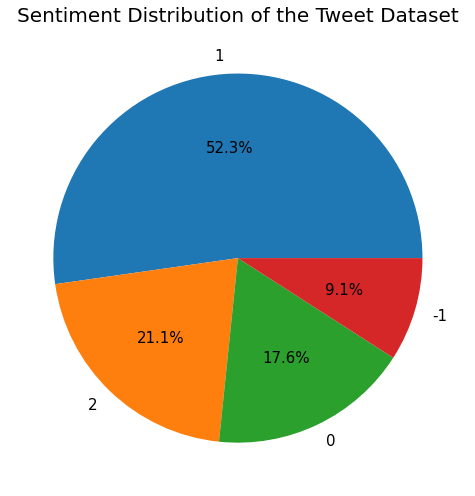

In [9]:
#Distribution of Sentiments
plt.figure(figsize = (7, 7))
plt.pie(df.sentiment.value_counts().values, labels = df.sentiment.value_counts().index, autopct = '%2.1f%%', textprops={'fontsize': 15})
plt.title('Sentiment Distribution of the Tweet Dataset', fontsize=20)
plt.tight_layout()
plt.show()


In [10]:
df.sentiment.value_counts()

 1    22962
 2     9276
 0     7715
-1     3990
Name: sentiment, dtype: int64

In [11]:
#Data Preparation for Sentiment Analysis

# separate the messages column for transformation.
dfTweets = df["message"]

In [12]:
#Tokenization
def createTokenizedArray(sentences):
    '''
    Create lower case array of words with no punctuation.
    :param sentences: array or series of texts
    :return: lower case array of words with no punctuation.
    '''
    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r'\w+')
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)

        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [13]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

0    [tiniebeany, climate, change, is, an, interesting, hustle, as, it, was, global, warmin...
1    [rt, natgeochannel, watch, beforetheflood, right, here, as, leodicaprio, travels, the,...
2    [fabulous, leonardo, dicaprio, s, film, on, climate, change, is, brilliant, do, watch,...
3    [rt, mick_fanning, just, watched, this, amazing, documentary, by, leonardodicaprio, on...
4    [rt, cnalive, pranita, biswasi, a, lutheran, from, odisha, gives, testimony, on, effec...
dtype: object

In [14]:
#Stop Word Removal

# To get stop words.
nltk.download('stopwords')

def removeStopWords(tokenList):
    '''
    Create array of words with no punctuation or stop words.
    :param tokenList: tokenized list
    :return: array of words with no punctuation or stop words.
    '''
    stopWords = set(stopwords.words('english'))
    shorterSentences = []  # Declare empty array of sentences.

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:

                # Remove leading and trailing spaces.
                word = word.strip()
# Ignore single character words and digits.
                if (len(word) > 1 and word.isdigit() == False):
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences

[nltk_data] Downloading package stopwords to C:\Users\SETUP
[nltk_data]     GAME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom']


Sample sentence AFTER removing stop words:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']


In [16]:
#Stemming
def stemWords(sentenceArrays):
    '''
    Removes suffixes and rebuilds the sentences.
    :param sentenceArrays: stentences list
    :return: array of sentences without suffixes
    '''
    ps = PorterStemmer()
    stemmedSentences = []
    for sentenceArray in sentenceArrays:
        stemmedArray = []  # Declare empty array of words.
        for word in sentenceArray:
            stemmedArray.append(ps.stem(word))  # Add stemmed word.

        # Convert array back to sentence of stemmed words.
        delimeter = ' '
        sentence = delimeter.join(stemmedArray)

        # Append stemmed sentence to list of sentences.
        stemmedSentences.append(sentence)
    return stemmedSentences

In [17]:
stemmedLi = stemWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE stemming:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER stemming:\n{stemmedLi[0]}")

Sample sentence BEFORE stemming:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']

Sample sentence AFTER stemming:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom


In [18]:
#Vectorization
def vectorizeList(stemmedList, ngramRangeStart, ngramRangeEnd):
    '''
    Creates a matrix of word vectors.
    :param stemmedList: stemmed sentence list
    :return: matrix of word vectors and vocabulary dictionary
    '''
    cv = CountVectorizer(binary=True, ngram_range=(ngramRangeStart, ngramRangeEnd))
    cv.fit(stemmedList)
    X = cv.transform(stemmedList)

    return X, cv.vocabulary_

In [19]:
vectorizedTweets, vectorDictionary = vectorizeList(stemmedLi, 1, 1)

In [20]:
print(f"Sample sentence #1:\n{stemmedLi[0]}")
print(f"Sample sentence #2:\n{stemmedLi[1]}")

Sample sentence #1:
tiniebeani climat chang interest hustl global warm planet stop warm ye suv boom
Sample sentence #2:
rt natgeochannel watch beforetheflood right leodicaprio travel world tackl climat chang http co lkdehj3tnn httã


In [21]:
print(f"\n#1 after vectorization:\n{vectorizedTweets[0]}")
print(f"#2 after vectorization:\n{vectorizedTweets[1]}")


#1 after vectorization:
  (0, 10652)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 24524)	1
  (0, 27759)	1
  (0, 29419)	1
  (0, 45475)	1
  (0, 54598)	1
  (0, 55193)	1
  (0, 57219)	1
  (0, 61855)	1
  (0, 64839)	1
#2 after vectorization:
  (0, 9419)	1
  (0, 12943)	1
  (0, 13774)	1
  (0, 14222)	1
  (0, 27583)	1
  (0, 27591)	1
  (0, 35060)	1
  (0, 35653)	1
  (0, 40355)	1
  (0, 49581)	1
  (0, 50386)	1
  (0, 55654)	1
  (0, 57882)	1
  (0, 61927)	1
  (0, 63129)	1


In [22]:
vectorizedTweets.shape

(43943, 67195)

In [23]:
#Bi-Grams :Using N-Grams, we can group N numbers of words together and analyze their frequencies for specific sentiment rating.
def generateWordList(wordDf, sentimentScore, n_gram_size):
    resultDf = wordDf[(wordDf['sentiment'] == sentimentScore)]

    sentences = [sentence.split() for sentence in resultDf['transformedTweets']]
    wordArray = []
    for i in range(0, len(sentences)):
        wordArray += sentences[i]

    counterList = Counter(ngrams(wordArray, n_gram_size)).most_common(80)

    counterDf = pd.DataFrame()

    delimiter = ' '
    print(f"\n***N-Gram (Sentiment: {sentimentScore})")
    for i in range(0, len(counterList)):
        counterDict = {
            "N-Gram" : delimiter.join(counterList[i][0])
            ,"Occurrences" : counterList[i][1]
        }
        # convert dict to series before concating to the dataframe.
        counterDict = pd.DataFrame(counterDict, index=[0])
        counterDf = pd.concat([counterDf, counterDict], ignore_index=True)

    return counterDf

In [24]:
# N-Gram variables
SIZE = 2
# add transformedTweets column to the original dataset with the stemmed data.
df['transformedTweets'] = stemmedLi
dfSub = df[['sentiment', 'transformedTweets']]


***N-Gram (Sentiment: -1)
                N-Gram  Occurrences
0         climat chang         2211
1              http co         1873
2          global warm         1855
3             man made          174
4           chang http          150
5     rt stevesgoddard          118
6            warm http          114
7              al gore          103
8              http rt           91
9   rt realdonaldtrump           87
10         made climat           86
11         made global           73
12             warm rt           72
13            chang rt           66
14          chang real           65
15         warm climat           61
16           warm hoax           60
17       believ climat           54
18          chang hoax           53
19         caus global           48


<AxesSubplot:title={'center':'Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

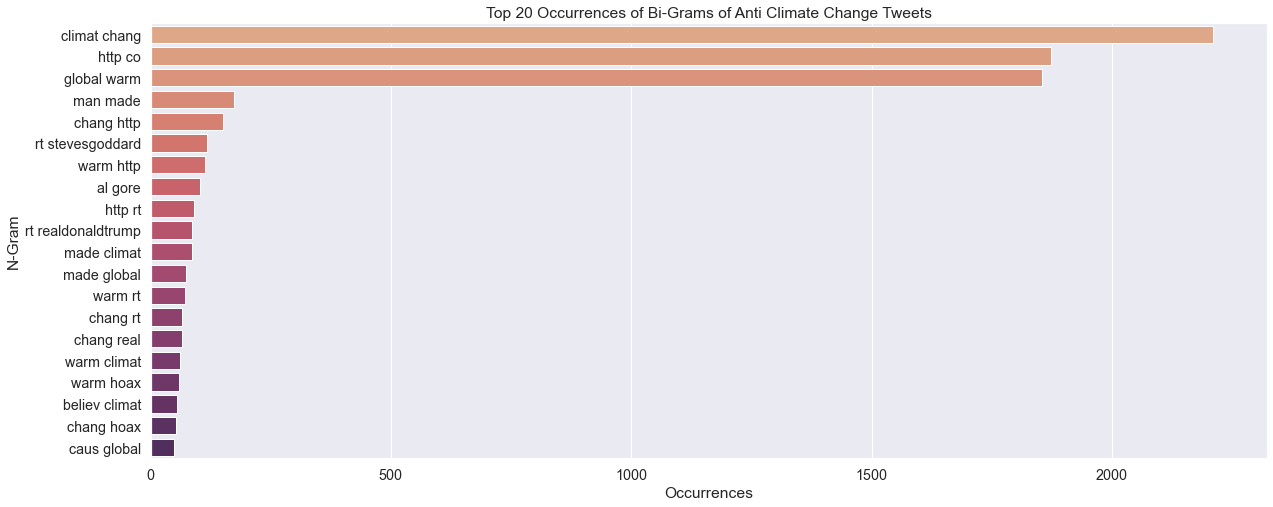

In [25]:
#Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets (-1)
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


***N-Gram (Sentiment: 0)
           N-Gram  Occurrences
0    climat chang         4491
1         http co         3271
2     global warm         3109
3      chang http          447
4       warm http          289
5         warm rt          236
6        chang rt          218
7     caus global          137
8       warm real          121
9         http rt          109
10  believ climat          107
11    talk climat           99
12          ðÿ ðÿ           88
13   think global           82
14   club penguin           82
15     chang real           81
16  believ global           75
17    caus climat           70
18   penguin shut           68
19     chang hoax           63


<AxesSubplot:title={'center':'Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

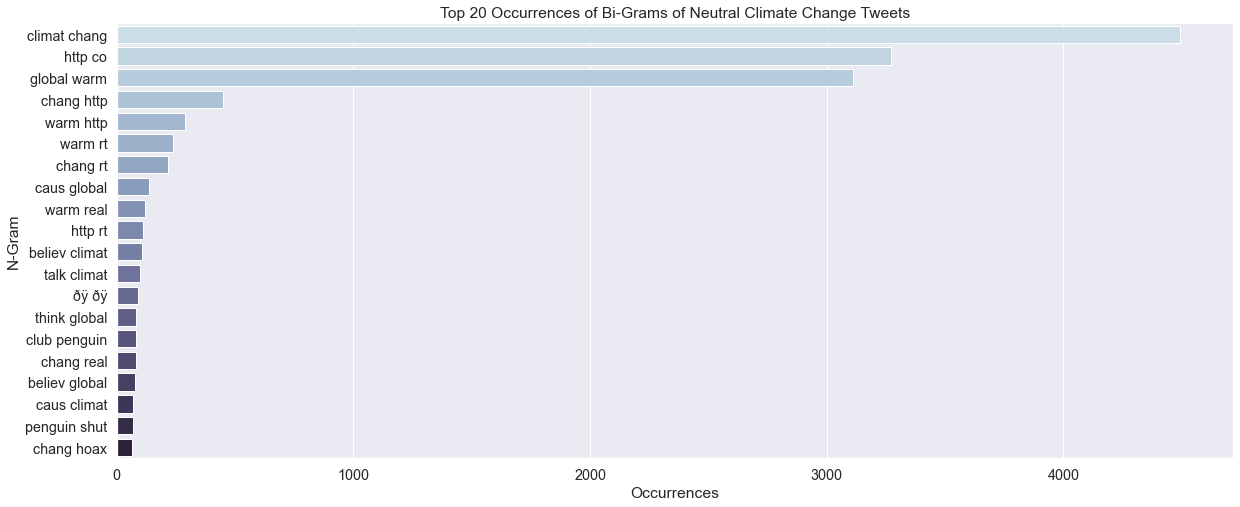

In [26]:
#Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets (0)
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Neutral Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")


***N-Gram (Sentiment: 1)
                   N-Gram  Occurrences
0            climat chang        19124
1                 http co        12378
2             global warm         3851
3              chang http         2799
4           believ climat         1427
5            fight climat          836
6                 http rt          788
7            chang denier          711
8              chang real          679
9                  go die          540
10               think go          514
11         husband believ          512
12            die husband          510
13     rt stephenschlegel          507
14  stephenschlegel think          507
15             co sjofonã          506
16              warm http          494
17               chang rt          477
18            deni climat          448
19             sjofonã rt          435


<AxesSubplot:title={'center':'Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

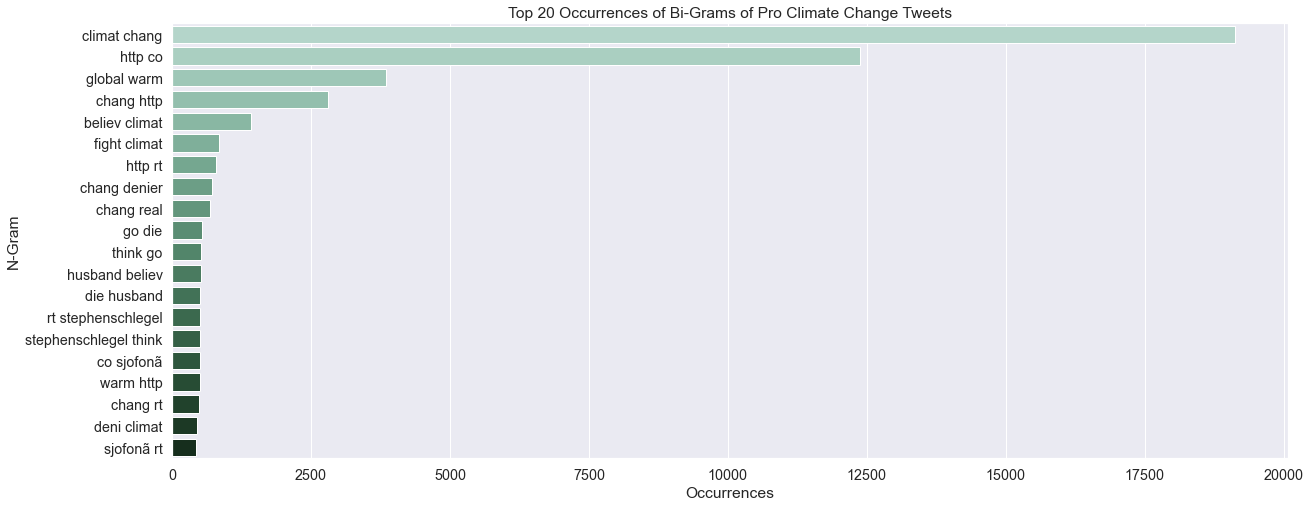

In [27]:
#Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets (1)
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of Pro Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.1,l=0.8")


***N-Gram (Sentiment: 2)
          N-Gram  Occurrences
0        http co        10199
1   climat chang         8102
2     chang http         2000
3    global warm         1196
4   fight climat          356
5      warm http          350
6   donald trump          269
7   trump climat          248
8        http rt          244
9   scott pruitt          218
10     rt thehil          208
11     epa chief          150
12   pari climat          129
13  tackl climat          126
14    say climat          126
15         co rt          126
16      say http          126
17    due climat          122
18     news http          121
19  chang polici          118


<AxesSubplot:title={'center':'Top 20 Occurrences of Bi-Grams of News Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

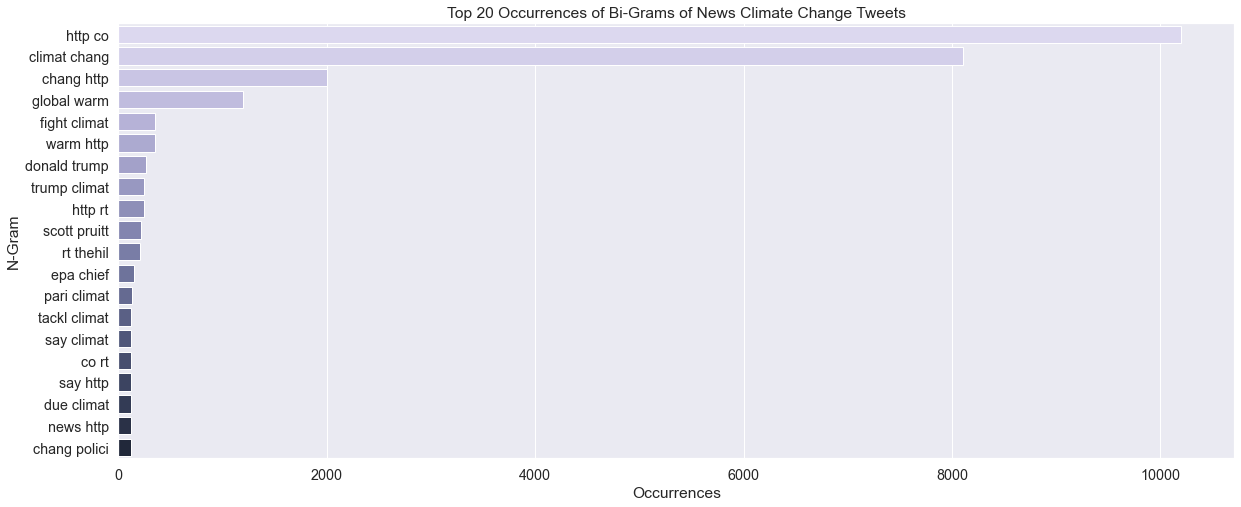

In [28]:
#Top 20 Occurrences of Bi-Grams of Factual Climate Change Tweets (2)
counterDfNews = generateWordList(dfSub, 2, SIZE)
counterDfNewsTop = counterDfNews.head(20)
print(counterDfNewsTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Bi-Grams of News Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="ch:2.8, r=.1")

In [29]:
#Tri-Grams
SIZE = 3


***N-Gram (Sentiment: -1)
                 N-Gram  Occurrences
0     climat chang http          146
1         chang http co          138
2      global warm http          112
3          warm http co          105
4     made climat chang           82
5       man made climat           78
6        global warm rt           71
7      made global warm           71
8       man made global           67
9     climat chang real           65
10      climat chang rt           61
11     global warm hoax           60
12   global warm climat           59
13    climat chang hoax           52
14  believ climat chang           52
15    warm climat chang           50
16     global warm data           45
17    caus climat chang           44
18     caus global warm           44
19    global warm creat           43


<AxesSubplot:title={'center':'Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

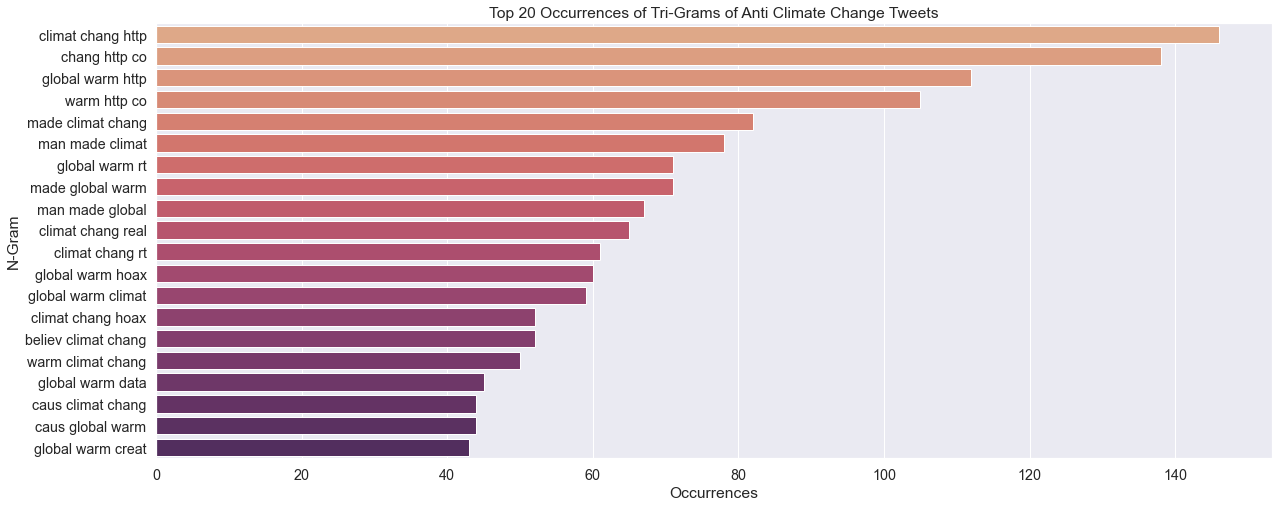

In [30]:
#Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets (-1)
counterDfAntiTop = generateWordList(dfSub, -1, SIZE)
counterDfAntiTop = counterDfAntiTop.head(20)
print(counterDfAntiTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Anti Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfAntiTop, palette="flare")


***N-Gram (Sentiment: 0)
                 N-Gram  Occurrences
0     climat chang http          444
1         chang http co          424
2      global warm http          289
3          warm http co          280
4        global warm rt          235
5       climat chang rt          214
6      caus global warm          137
7      global warm real          121
8   believ climat chang          106
9     talk climat chang           96
10    think global warm           81
11    climat chang real           81
12   believ global warm           74
13    caus climat chang           69
14    club penguin shut           68
15    climat chang hoax           63
16   think climat chang           58
17     stop global warm           57
18   fight climat chang           56
19     say climat chang           52


<AxesSubplot:title={'center':'Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

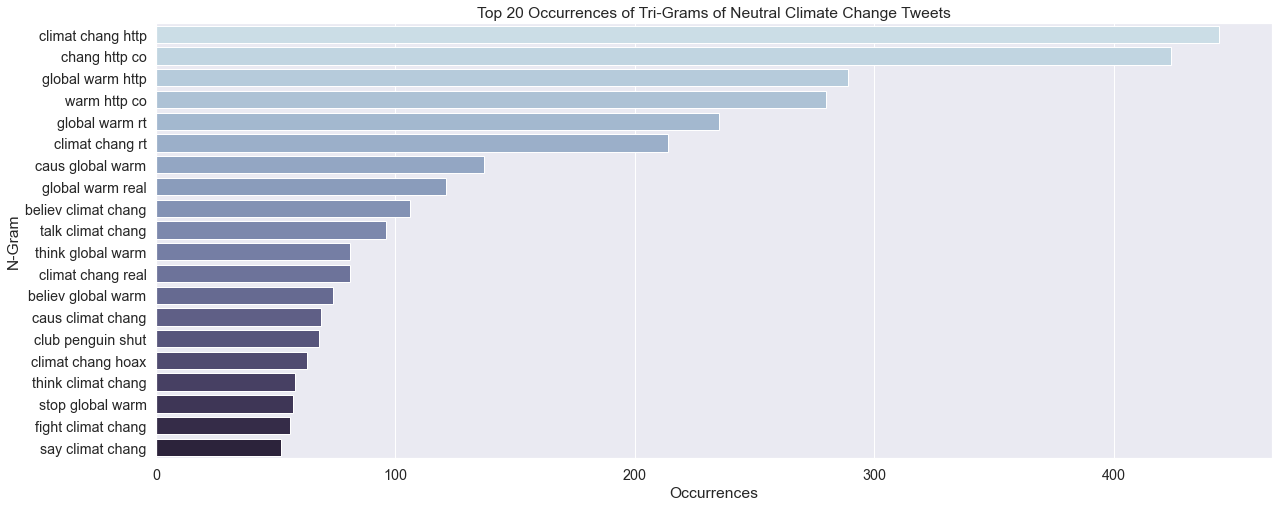

In [31]:
#Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets (0)
counterDfNeutral = generateWordList(dfSub, 0, SIZE)
counterDfNeutralTop = counterDfNeutral.head(20)
print(counterDfNeutralTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Neutral Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNeutralTop, palette="ch:s=.25,rot=-.25")


***N-Gram (Sentiment: 1)
                      N-Gram  Occurrences
0          climat chang http         2787
1              chang http co         2635
2        believ climat chang         1422
3         fight climat chang          822
4        climat chang denier          711
5          climat chang real          679
6      husband believ climat          512
7               think go die          510
8             go die husband          510
9         die husband believ          510
10  rt stephenschlegel think          507
11  stephenschlegel think go          507
12           http co sjofonã          506
13          global warm http          480
14              warm http co          470
15           climat chang rt          465
16             co sjofonã rt          435
17         deni climat chang          428
18        tackl climat chang          385
19       combat climat chang          366


<AxesSubplot:title={'center':'Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

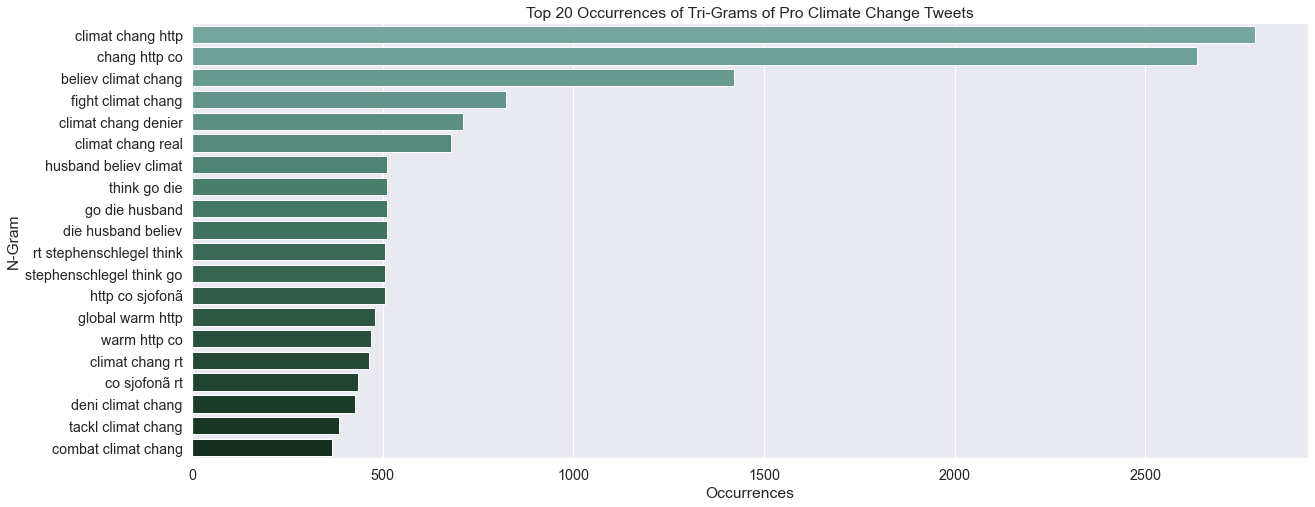

In [32]:
#Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets (1)
counterDfPro = generateWordList(dfSub, 1, SIZE)
counterDfProTop = counterDfPro.head(20)
print(counterDfProTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of Pro Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfProTop, palette="ch:2,r=.2,l=.6")


***N-Gram (Sentiment: 2)
                    N-Gram  Occurrences
0        climat chang http         1998
1            chang http co         1964
2       fight climat chang          355
3         global warm http          348
4             warm http co          346
5       trump climat chang          244
6               http co rt          126
7       tackl climat chang          125
8         say climat chang          124
9         due climat chang          122
10            news http co          121
11             say http co          121
12       pari climat chang          117
13     climat chang polici          116
14     action climat chang           96
15     effect climat chang           88
16      climat chang could           82
17           studi http co           81
18  climat chang agreement           80
19       talk climat chang           79


<AxesSubplot:title={'center':'Top 20 Occurrences of Tri-Grams of News Climate Change Tweets'}, xlabel='Occurrences', ylabel='N-Gram'>

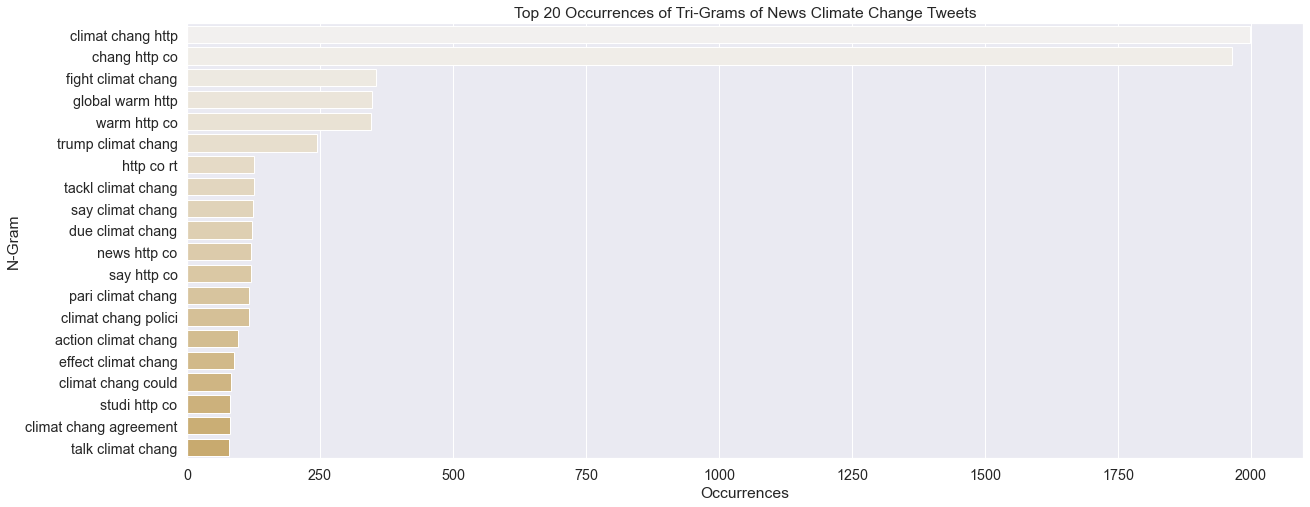

In [33]:
#Top 20 Occurrences of Tri-Grams of Factual Climate Change Tweets (2)
counterDfNews = generateWordList(dfSub, 2, SIZE)
counterDfNewsTop = counterDfNews.head(20)
print(counterDfNewsTop)

sns.set(font_scale = 1.3)
plt.figure(figsize=(20,8))
plt.title("Top 20 Occurrences of Tri-Grams of News Climate Change Tweets")
sns.set_style('darkgrid')
sns.barplot(x="Occurrences", y="N-Gram", data=counterDfNewsTop, palette="light:#D7AF60")

In [34]:
#Model Development

def evaluateModel(model, X_test, y_test, title):
    '''
    print out classification scores
    :param model: used model
    :param X_test:
    :param y_test:
    :param title: title of the model
    '''
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average='weighted')
    precision = metrics.precision_score(y_test, predictions, average='weighted')
    f1 = metrics.f1_score(y_test, predictions, average='weighted')

    clsScoreDict = {
        "accuracy": accuracy
        , "recall": recall
        , "precision": precision
        , "f1": f1
    }
    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))
    print("\n\n")

    return clsScoreDict

In [35]:
def modelAndPredict(X, target, model):
    '''
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    '''

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(
        X, target, train_size=0.75
    )

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)
    clsScoreDict = evaluateModel(clfModel, X_test, y_test, modelType)
     # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict


In [36]:
def showFormattedConfusionMatrix(y_test, y_predicted):
    '''
    Draw the confusion matrix.
    :param y_test
    :param y_predicted
    :return:
    '''
    # print a simple confusion matrix
    cm = metrics.confusion_matrix(y_test.values, y_predicted)
    print(cm)

    # Show confusion matrix with colored background.
    Index = ['Actual -1', 'Actual 0', 'Actual 1', 'Actual 2', ]
    Cols = ['Pred -1', 'Pred 0', 'Pred 1', 'Pred 2']
    df = pd.DataFrame(cm, index=Index, columns=Cols)
    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(df, cmap='Blues', annot=True, fmt='g')
    bottom, top = ax.get_ylim()
    ax.set(title="Movie Review Sentiment")
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30,
                       horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0,
                       horizontalalignment='right')
    

In [37]:
# bi-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 2

vectorizedTweets2, vectorDictionary2 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [38]:
# tri-gram vectorization
NGRAM_RANGE_START = 3
NGRAM_RANGE_END = 3

vectorizedTweets3, vectorDictionary3 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [39]:
# bi-gram & tri-gram vectorization
NGRAM_RANGE_START = 2
NGRAM_RANGE_END = 3

vectorizedTweets23, vectorDictionary23 = vectorizeList(stemmedLi, NGRAM_RANGE_START, NGRAM_RANGE_END)

In [40]:
#1. Logistic Regression
model = LogisticRegression()


*** LogisticRegression ***
Accuracy:  0.737119970872019
Precision: 0.7319594151390647
Recall:    0.737119970872019
F1:        0.7325323239854389



[[ 500  172  235   59]
 [  96  972  655  136]
 [  95  431 4821  417]
 [  23   94  475 1805]]


C:\Users\SETUP GAME\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


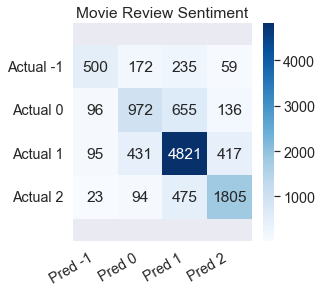

In [41]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)


*** LogisticRegression ***
Accuracy:  0.7114509375568906
Precision: 0.7106746980757357
Recall:    0.7114509375568906
F1:        0.6944493802726435



[[ 341  205  415   52]
 [  50  782 1000   84]
 [  36  301 5058  320]
 [   5   51  651 1635]]


C:\Users\SETUP GAME\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


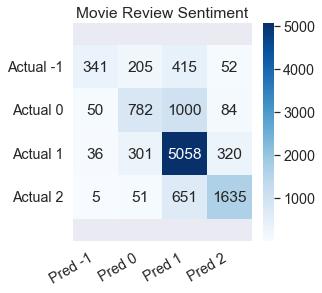

In [42]:
#Bi-Gram Logistic Regression
X_test, y_test, y_predicted, lrScoreDict2 = modelAndPredict(vectorizedTweets2, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)


*** LogisticRegression ***
Accuracy:  0.663116693974149
Precision: 0.6661752128506724
Recall:    0.663116693974149
F1:        0.6288234393884653



[[ 203  128  584   36]
 [  32  515 1318   83]
 [  39  223 5225  258]
 [  10   58  932 1342]]


C:\Users\SETUP GAME\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


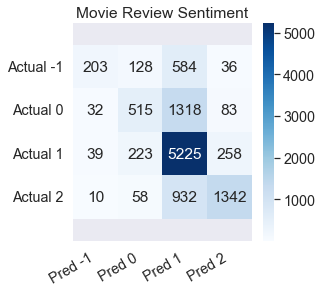

In [43]:
#Tri-gram Logistic Regression
X_test, y_test, y_predicted, lrScoreDict3 = modelAndPredict(vectorizedTweets3, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)


*** LogisticRegression ***
Accuracy:  0.6943382486801384
Precision: 0.6922607583839999
Recall:    0.6943382486801384
F1:        0.6767483411147842



[[ 290  229  436   49]
 [  35  753  995  103]
 [  36  409 5056  325]
 [  13   52  676 1529]]


C:\Users\SETUP GAME\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


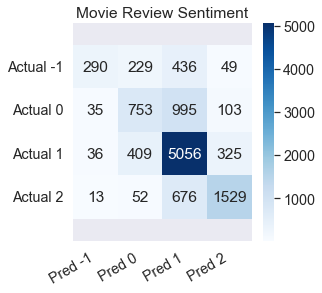

In [44]:
#Bi-Gram & Tri-Gram Logistic Regression
X_test, y_test, y_predicted, lrScoreDict23 = modelAndPredict(vectorizedTweets23, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

In [45]:
#N-gram Comparisons
lsScoreDf = pd.DataFrame(lrScoreDict, index=["-"])
lsScoreDf2 = pd.DataFrame(lrScoreDict2, index=["Bi-gram"])
lsScoreDf3 = pd.DataFrame(lrScoreDict3, index=["Tri-gram"])
lsScoreDf23 = pd.DataFrame(lrScoreDict23, index=["Bi-gram and Tri-gram"])

lsScoreComparisonDf = pd.concat([lsScoreDf, lsScoreDf2, lsScoreDf3, lsScoreDf23])
lsScoreComparisonDf

,accuracy,recall,precision,f1
-,0.737120,0.737120,0.731959,0.732532
Bi-gram,0.711451,0.711451,0.710675,0.694449
Tri-gram,0.663117,0.663117,0.666175,0.628823
Bi-gram and Tri-gram,0.694338,0.694338,0.692261,0.676748


In [46]:
#2. Decision Tree
model = DecisionTreeClassifier(max_depth=20)


*** DecisionTreeClassifier ***
Accuracy:  0.6092299290005462
Precision: 0.6136513191321546
Recall:    0.6092299290005462
F1:        0.5555224912755938



[[ 193   77  696   60]
 [  50  301 1494   84]
 [  52  138 5266  293]
 [  18    9 1322  933]]


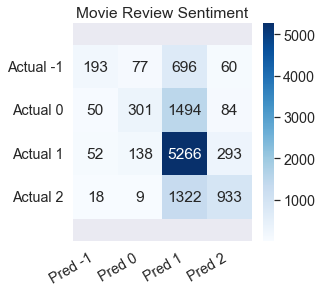

In [47]:
X_test, y_test, y_predicted, treeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

In [48]:
#3. Random Forest Classifier
model = RandomForestClassifier()



*** RandomForestClassifier ***
Accuracy:  0.700072819952667
Precision: 0.7045919674098508
Recall:    0.700072819952667
F1:        0.6818469815499785



[[ 283  231  441   47]
 [  24  815  959  107]
 [  23  354 5065  311]
 [   8   32  758 1528]]


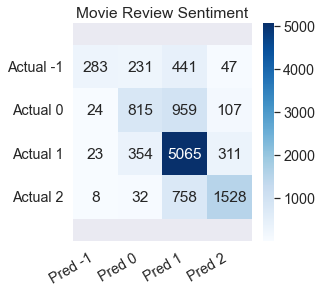

In [49]:
X_test, y_test, y_predicted, rfScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

In [50]:
#4. K Neighbors Classifier
model = KNeighborsClassifier()


*** KNeighborsClassifier ***
Accuracy:  0.4313671946113235
Precision: 0.6181516824672553
Recall:    0.4313671946113235
F1:        0.44933052757123454



[[ 178  669  140    7]
 [ 113 1543  256   16]
 [ 188 3204 2287  101]
 [  57  905  591  731]]


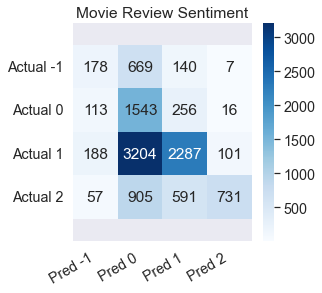

In [51]:
X_test, y_test, y_predicted, knnScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

In [52]:
#5. Linear Support Vector Classifier (SVC)
model = SVC()


*** SVC ***
Accuracy:  0.7277444019661388
Precision: 0.7288041656955434
Recall:    0.7277444019661388
F1:        0.7107369494832404



[[ 366  160  417   50]
 [  52  796  974   99]
 [  27  224 5149  326]
 [  10   35  617 1684]]


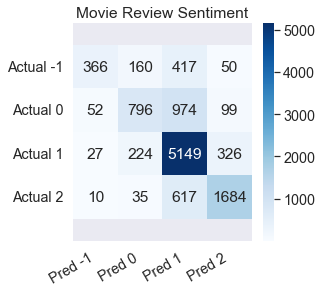

In [53]:
X_test, y_test, y_predicted, svcScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

In [54]:
#6. Ridge Classifier
model = RidgeClassifier()


*** RidgeClassifier ***
Accuracy:  0.7189149827052612
Precision: 0.7129303300438523
Recall:    0.7189149827052612
F1:        0.7113942726538044



[[ 478  164  281   64]
 [  85  890  757  160]
 [  68  431 4875  413]
 [  17   78  570 1655]]


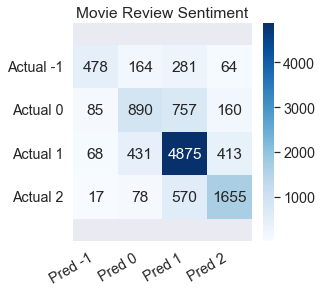

In [55]:
X_test, y_test, y_predicted, ridgeScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

In [61]:
lrScoreDf = pd.DataFrame(lrScoreDict, index=["Logistic Regression"])
treeScoreDf = pd.DataFrame(treeScoreDict, index=["Decision Tree"])
rfScoreDf = pd.DataFrame(rfScoreDict, index=["Random Forest Classification"])
knnScoreDf = pd.DataFrame(knnScoreDict, index=["K Neighbors Classification"])
svcScoreDf = pd.DataFrame(svcScoreDict, index=["Linear Support Vector Classifier Classification"])
ridgeScoreDf = pd.DataFrame(ridgeScoreDict, index=["Ridge Classification"])

clsCompDf = pd.concat([lrScoreDf, treeScoreDf, rfScoreDf, knnScoreDf, svcScoreDf, ridgeScoreDf])

clsCompDf.sort_values(by=["accuracy", "f1"], ascending = False)

,accuracy,recall,precision,f1
Logistic Regression,0.737120,0.737120,0.731959,0.732532
Linear Support Vector Classifier Classification,0.727744,0.727744,0.728804,0.710737
Ridge Classification,0.718915,0.718915,0.712930,0.711394
Random Forest Classification,0.700073,0.700073,0.704592,0.681847
Decision Tree,0.609230,0.609230,0.613651,0.555522
K Neighbors Classification,0.431367,0.431367,0.618152,0.449331


In [62]:
#Binary File Export

def modelAndPredict(X, target, model):
    '''
    Build model and predict scores.

    :param X: X contains the stemmed and vectorized sentences.
    :param target: the sentiment rating
    :param model: selected model
    :return: X_test, y_test, and y_predicted values.
    '''

    modelType = model.__class__.__name__

    # Create training set with 75% of data and test set with 25% of data.
    X_train, X_test, y_train, y_test = train_test_split(
        X, target, train_size=0.75
    )

    # Build the model with the training data.
    clfModel = model.fit(X_train, y_train)

    # save model to a pickle file
    # create directory for models
    if (not path.exists("./model")):
        makedirs('./model')
    pickle.dump(clfModel, open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "wb"))

    # load model
    loadedModel = pickle.load(open(f"./model/climate_change_tweet_sentiment_{modelType}.dat", "rb"))

    clsScoreDict = evaluateModel(loadedModel, X_test, y_test, modelType)


    # Predict target values.
    y_prediction = model.predict(X_test)

    return X_test, y_test, y_prediction, clsScoreDict
    

In [63]:
model = LogisticRegression()


*** LogisticRegression ***
Accuracy:  0.731476424540324
Precision: 0.7257124239015219
Recall:    0.731476424540324
F1:        0.7264405134520113



[[ 492  178  217   68]
 [ 107 1039  716  138]
 [ 101  444 4779  411]
 [  13   89  468 1726]]


C:\Users\SETUP GAME\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


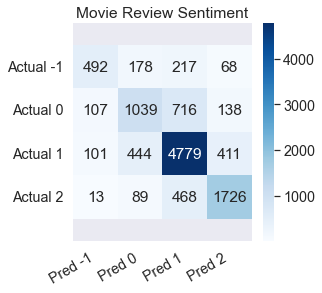

In [64]:
X_test, y_test, y_predicted, lrScoreDict = modelAndPredict(vectorizedTweets, df['sentiment'], model)
showFormattedConfusionMatrix(y_test, y_predicted)

In [65]:
with open("wordDictionary.json", "w") as fp:
    json.dump(vectorDictionary, fp)